<h1>Full Fledged Recommender System</h1>
<br>
<p>by Krishna yogi , Data Scientist / AI specalist <br><br>

I created a full fledged recommender system. Restricted Boltzman Machine, Auto Encoders and Collaborative filtering (CF) techniques used for our recommender system. (Collaborative filtering using Pearson Correlation (PC) is not appropriate for this data set, why is explained in related cell. I included Collaborative filtering with Pearson Correlation because it's a challenge. If we increase size of data set, CF with PC will work smoothly)
<br> <br>
Restrictions for this challenge :
<br>
Time ( I was not able to spend enough time to follow every steps. I just made note of what needs to be done and move to next step )
<br>
Computation Power (Since I used my laptop with cpu, I was not able to complete all steps necessary for training. For example I mentioned grid search but I did not apply it, because it is computationally too expensive)
<br><br>
Pipeline :
<br>
1. Receive an input from user x<br>
2. Tokenize input, remove punctuations, stop words<br>
3. Check the input tokens match with the business features or not (I created business features by tf-idf of reviews + internet research. You can see more details on the cells, about the business features matrix)<br>
4. Filter the businesses, according to the user input tokens match with the business features<br>
5. Predict whether user will like the reataurant or not, using Restricted Boltzman Machine<br>
6. From the restaurants that RBM resulted user will like, take the top 3 which ones has the the highest stars<br>
7. If RBM is not able to return 3 restaurants, Stacked auto encoders will predict the stars that specific user will give to the each business. <br>
8. Take the top 3 prediction merge with the RBM results. <br>
9. If still we are not able to return 3 restaurants, take the businesses with the highest stars and pick 3, merge with previous prediction <br>
10. Return 3 restaurants user will like<br>
11. See the flask application 
</p>

In [16]:
import urllib.request    
import pandas as pd
import numpy as np

In [3]:
#download the link 
csvlink ='https://raw.githubusercontent.com/yalcinmurat1986/full-fledged-recommender-system/master/dataset_food_online.txt'
urllib.request.urlretrieve(csvlink, "/Users/krissy/Downloads/dataset_food_online.txt")

('/Users/krissy/Downloads/dataset_food_online.txt',
 <http.client.HTTPMessage at 0x11227f240>)

In [7]:
# directly read to df
import pandas as pd
csvlink ='https://raw.githubusercontent.com/yalcinmurat1986/full-fledged-recommender-system/master/dataset_food_online.txt'
data = pd.read_csv(csvlink,sep=',', encoding = 'latin-1')
data.shape


(10000, 10)

In [8]:
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate.]Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


<h2>Plotting the graph for histogram of star ratings</h2>


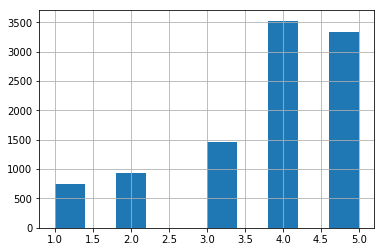

In [11]:
data.stars.hist()

In [14]:
print(data.business_id.nunique())
print(data.user_id.nunique())


4174
6403


In [17]:
print(data.cool.nunique())
print(np.sort(data.cool.unique()))
print(data.useful.nunique())
print(np.sort(data.useful.unique()))
print(data.funny.nunique())
print(np.sort(data.funny.unique()))

29
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 27 28 32 38 77]
28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 23 24 28
 30 31 38 76]
29
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 27 30 39 57]


In [18]:
data.isnull().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64

<h3> label encoding text items like business id, review id and user id helps in treating them as numerical vectors</h3>

In [20]:
from sklearn.preprocessing import LabelEncoder

labelbusines = LabelEncoder()
labelreview = LabelEncoder()
labeluser = LabelEncoder()

data.business_id = labelbusines.fit_transform(data.business_id)

data.review_id = labelreview.fit_transform(data.review_id)

data.user_id = labeluser.fit_transform(data.user_id)


In [24]:
#converting date to date time 
data.date = pd.to_datetime(data.date ,format ='%Y-%m-%d')

In [30]:
print(data.date.min(),data.date.max())

2005-04-18 00:00:00 2013-01-05 00:00:00


In [33]:
data = data.sort_values('user_id')

In [34]:
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
2449,2640,2010-09-29,7156,5,This review has been waiting and waiting for m...,review,0,1,2,1
2423,3589,2010-08-03,9341,4,Throwing the picture of Sheriff Arpaio on the ...,review,0,2,2,0
5785,3134,2011-06-29,1054,4,"There's no doubt about it, both Mamma Mia loca...",review,0,3,5,2
9061,3062,2011-05-23,2060,5,For those of you who love Indian/Pakistani foo...,review,0,3,3,0
2710,3250,2010-12-20,3286,4,I knew when I was heading to Papago Brewing th...,review,0,4,4,1


In [31]:
data.describe()

,business_id,review_id,stars,user_id,cool,useful,funny
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2094.555600,4999.50000,3.777500,3177.751700,0.876800,1.409300,0.701300
std,1205.622291,2886.89568,1.214636,1865.012161,2.067861,2.336647,1.907942
min,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1058.000000,2499.75000,3.000000,1531.000000,0.000000,0.000000,0.000000
50%,2114.500000,4999.50000,4.000000,3195.500000,0.000000,1.000000,0.000000
75%,3134.000000,7499.25000,5.000000,4800.000000,1.000000,2.000000,1.000000
max,4173.000000,9999.00000,5.000000,6402.000000,77.000000,76.000000,57.000000


<p>For anybody who wants to return encryped business names Instead of id numbers</p>

In [35]:
inv = labeluser.inverse_transform(data.user_id)
print(inv)

['--65q1FpAL_UQtVZ2PTGew' '--65q1FpAL_UQtVZ2PTGew'
 '--65q1FpAL_UQtVZ2PTGew' ... 'zxnoE5IjuWoI9mF1gwyg5w'
 'zzhdnNeg65wupOXqYtGyJw' 'zzmRKNph-pBHDL2qwGv9Fw']


In [36]:
# split data as a train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.5,random_state=0)